In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from resnet_models import create_resnet50_model
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback, WandbEvalCallback

In [2]:
# initialize wandb
wandb.init(project="ResNet", config={
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 10,
    "verbose": 1,
    "architecture": "ResNet50V1"
})
# configs
cfg = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gabri-torland (nubs). Use `wandb login --relogin` to force relogin


# Loading Data Set
Three sets are created: training, validation, and test. 
- Labels are generated based on the folder structure. Class name must correspond to the subfolder name.
- Loading in batches, of size 32, to reduce memory usage.
- Label mode is set to categorical, which means that the labels are encoded as a categorical vector.

Bilinear interploation is set to default. This specify the method used in the resizing procedure. By default aspect ratio is not perserved, i.e., the ratio between image width and height.

One hot encoding is utilized when label mode is set to categorical.


The image load documentation is available [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) and an example is available [here](https://keras.io/api/data_loading/image/).

In [4]:
train_ds = keras.utils.image_dataset_from_directory(
    directory="dataset/train",
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    batch_size=cfg.batch_size,
    image_size=(224, 224)
    )
val_ds = keras.utils.image_dataset_from_directory(
    directory="dataset/val",
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
    batch_size=cfg.batch_size,
    image_size=(224, 224)
    )
test_ds = keras.utils.image_dataset_from_directory(
    directory="dataset/test",
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    batch_size=cfg.batch_size,
    image_size=(224, 224)
    )

Found 297792 files belonging to 12 classes.
Found 37219 files belonging to 12 classes.
Found 37235 files belonging to 12 classes.


# Visualizing the Data

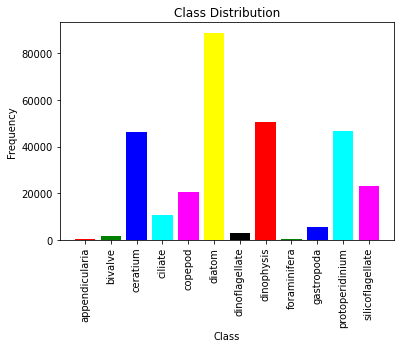

In [5]:
# histogram of class distribution in the data set
# remove underscores from class names
class_dist = {class_name.replace('_', ' ') : 0 for class_name in train_ds.class_names}
for label in os.listdir("dataset/train"):
    class_dist[label.replace('_', ' ')] = len(os.listdir(os.path.join("dataset/train/", label)))

# plot the histogram
plt.bar(class_dist.keys(), class_dist.values(), color=['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


In [6]:
for label, count in zip(class_dist.keys(), class_dist.values()):
    print(f'{label}: {count/sum(class_dist.values())*100:.2f}%')

appendicularia: 0.08%
bivalve: 0.56%
ceratium: 15.59%
ciliate: 3.64%
copepod: 6.85%
diatom: 29.81%
dinoflagellate: 1.05%
dinophysis: 17.01%
foraminifera: 0.12%
gastropoda: 1.89%
protoperidinium: 15.65%
silicoflagellate: 7.76%


# Model Creation

In [7]:
def layer_state(model):
    for i, layer in enumerate(model.layers):
        print(i, layer.name, "-" ,layer.trainable)

In [8]:
print(len(train_ds.class_names))
model = create_resnet50_model(len(train_ds.class_names))
# print the layer state
layer_state(model)

12
0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv

In [9]:
# list of callbacks
callbacks = [
            WandbCallback(mode="min", monitor="val_loss", save_graph=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
          ]

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [ ]:
model.fit(train_ds, epochs=cfg.epochs, batch_size=cfg.batch_size, verbose=cfg.verbose, validation_data=val_ds, callbacks=callbacks) # train the model

Epoch 1/10


2023-03-15 13:46:18.440493: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


9306/9306 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.9378

In [ ]:
wandb.finish()